In [1]:
# Environment Setup and Library Imports
import fastf1
import fastf1.plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Enable FastF1 cache for faster data loading
fastf1.Cache.enable_cache('../cache')
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

print('FastF1 Animation Environment Ready.')
print(f'FastF1 Version: {fastf1.__version__}')

FastF1 Animation Environment Ready.
FastF1 Version: 3.7.0


## 1. Load Session Data
Load race session and telemetry data from FastF1 API.

In [2]:
# Load 2025 Qatar GP Race Session
year = 2025
race = 'Qatar'
session_type = 'R'  # R=Race, Q=Qualifying, FP1/FP2/FP3

print(f'Loading {year} {race} GP - Race Session...')
session = fastf1.get_session(year, race, session_type)
session.load()

print(f'Session loaded: {session.event["EventName"]}')
print(f'Date: {session.date}')
print(f'Drivers: {len(session.drivers)}')

Loading 2025 Qatar GP - Race Session...


events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18', '6', '87

Session loaded: Qatar Grand Prix
Date: 2025-11-30 16:00:00
Drivers: 20


In [3]:
# Get fastest lap for each driver
drivers_info = []
for driver in session.drivers:
    try:
        drv_laps = session.laps.pick_driver(driver)
        fastest = drv_laps.pick_fastest()
        if fastest is not None:
            drivers_info.append({
                'Driver': driver,
                'DriverName': fastest['Driver'],
                'Team': fastest['Team'],
                'LapTime': fastest['LapTime']
            })
    except:
        pass

drivers_df = pd.DataFrame(drivers_info).sort_values('LapTime')
print('Fastest Laps by Driver:')
drivers_df.head(10)

Fastest Laps by Driver:


,Driver,DriverName,Team,LapTime
1,81,PIA,McLaren,0 days 00:01:22.996000
3,4,NOR,McLaren,0 days 00:01:23.197000
5,63,RUS,Mercedes,0 days 00:01:23.198000
16,18,STR,Aston Martin,0 days 00:01:23.484000
0,1,VER,Red Bull Racing,0 days 00:01:23.498000
2,55,SAI,Williams,0 days 00:01:23.859000
6,14,ALO,Aston Martin,0 days 00:01:23.940000
4,12,ANT,Mercedes,0 days 00:01:23.955000
8,30,LAW,Racing Bulls,0 days 00:01:23.971000
9,22,TSU,Red Bull Racing,0 days 00:01:24.139000


## 2. Racing Line Visualization
Static track map with racing line colored by speed.

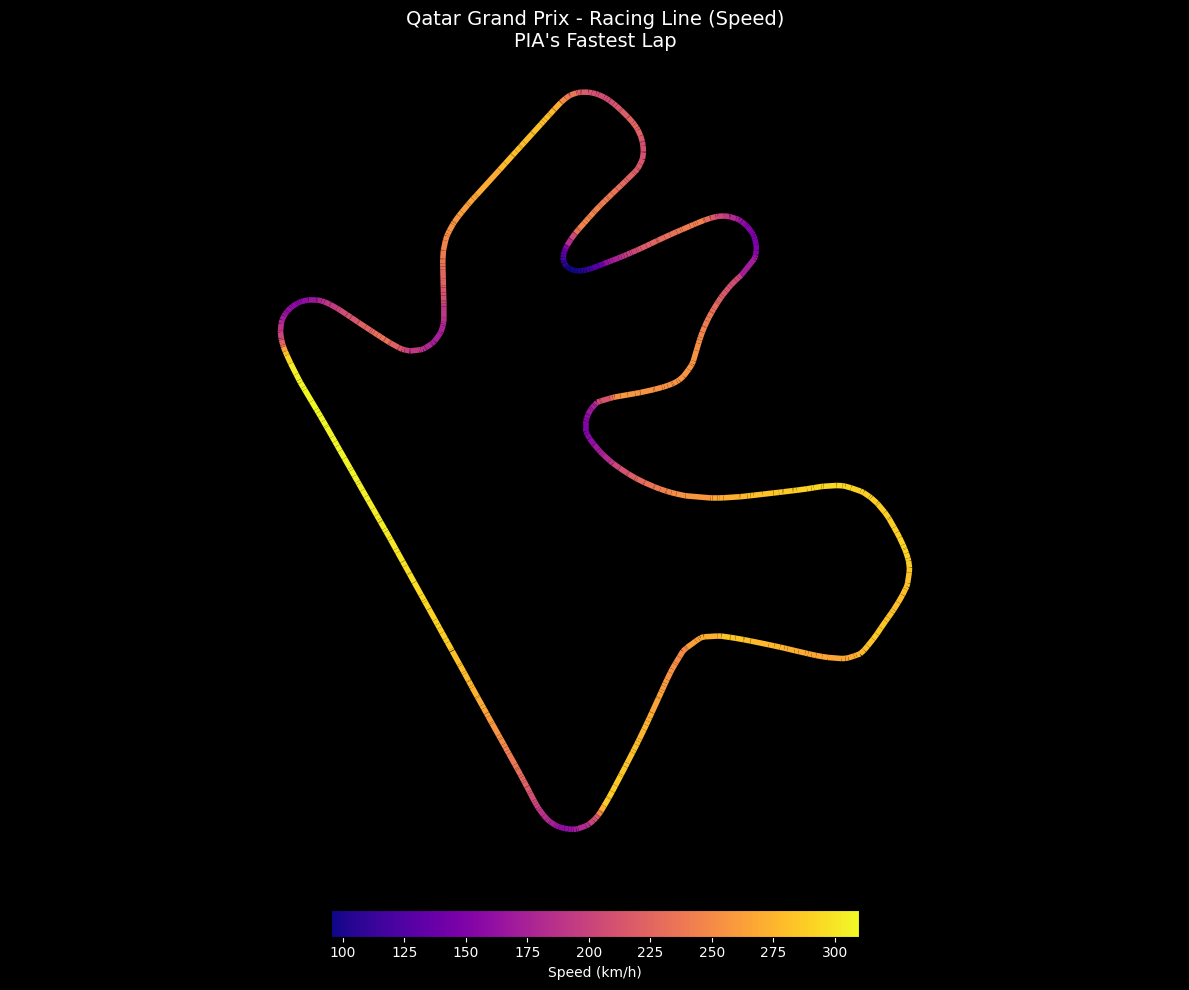

In [4]:
# Get fastest lap telemetry for racing line
fastest_lap = session.laps.pick_fastest()
tel = fastest_lap.get_telemetry()

# Create racing line colored by speed
x = tel['X'].values
y = tel['Y'].values
speed = tel['Speed'].values

# Create line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(figsize=(12, 10), facecolor='black')
ax.set_facecolor('black')

# Color by speed
norm = plt.Normalize(speed.min(), speed.max())
lc = LineCollection(segments, cmap='plasma', norm=norm)
lc.set_array(speed)
lc.set_linewidth(4)

ax.add_collection(lc)
ax.autoscale()
ax.axis('equal')
ax.axis('off')

cbar = fig.colorbar(lc, ax=ax, orientation='horizontal', pad=0.05, fraction=0.03)
cbar.set_label('Speed (km/h)', color='white')
cbar.ax.xaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='white')

plt.title(f"{session.event['EventName']} - Racing Line (Speed)\n{fastest_lap['Driver']}'s Fastest Lap", 
          color='white', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Driver Battle Comparison
Compare two drivers' telemetry head-to-head.

In [5]:
# Select two drivers for comparison
driver1 = 'NOR'  # Norris
driver2 = 'VER'  # Verstappen

# Get fastest laps
lap1 = session.laps.pick_driver(driver1).pick_fastest()
lap2 = session.laps.pick_driver(driver2).pick_fastest()

tel1 = lap1.get_telemetry().add_distance()
tel2 = lap2.get_telemetry().add_distance()

# Get team colors
color1 = fastf1.plotting.get_team_color(lap1['Team'], session)
color2 = fastf1.plotting.get_team_color(lap2['Team'], session)

print(f'Comparing: {lap1["Driver"]} vs {lap2["Driver"]}')
print(f'Lap Times: {lap1["LapTime"]} vs {lap2["LapTime"]}')

req            INFO 	Using cached data for driver_info


Comparing: NOR vs VER
Lap Times: 0 days 00:01:23.197000 vs 0 days 00:01:23.498000


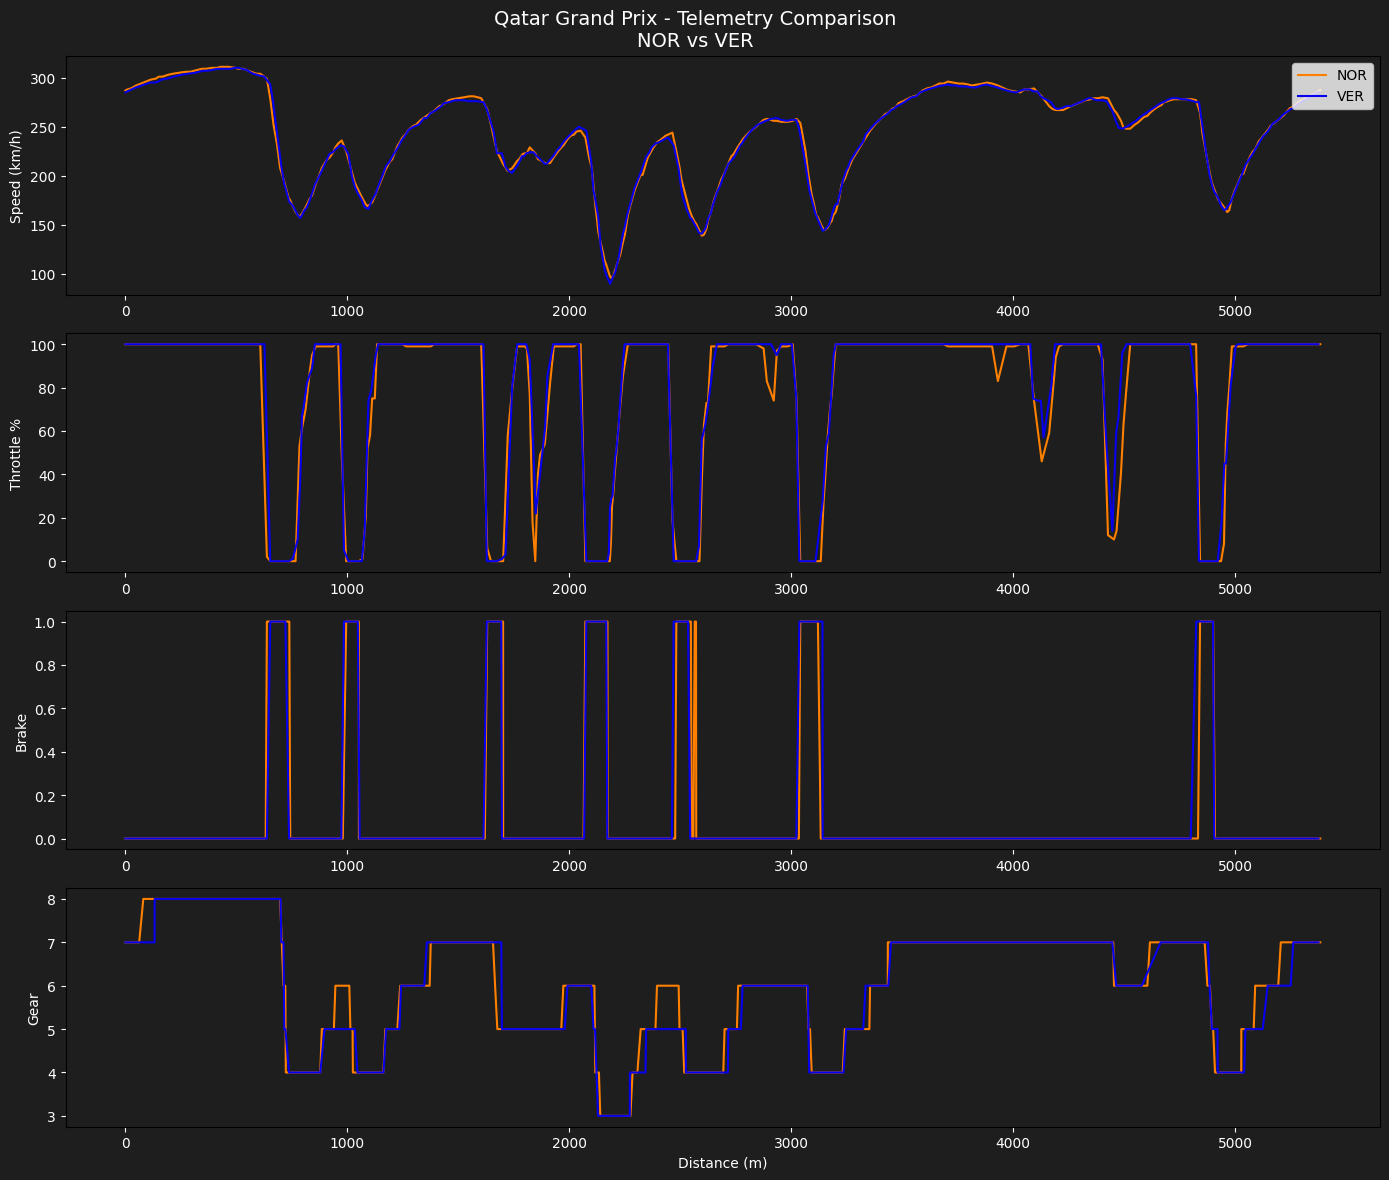

In [6]:
# Create multi-panel telemetry comparison
fig, axes = plt.subplots(4, 1, figsize=(14, 12), facecolor='#1e1e1e')

# Speed comparison
axes[0].plot(tel1['Distance'], tel1['Speed'], color=color1, label=lap1['Driver'], linewidth=1.5)
axes[0].plot(tel2['Distance'], tel2['Speed'], color=color2, label=lap2['Driver'], linewidth=1.5)
axes[0].set_ylabel('Speed (km/h)', color='white')
axes[0].legend(loc='upper right')
axes[0].set_facecolor('#1e1e1e')
axes[0].tick_params(colors='white')

# Throttle comparison
axes[1].plot(tel1['Distance'], tel1['Throttle'], color=color1, linewidth=1.5)
axes[1].plot(tel2['Distance'], tel2['Throttle'], color=color2, linewidth=1.5)
axes[1].set_ylabel('Throttle %', color='white')
axes[1].set_facecolor('#1e1e1e')
axes[1].tick_params(colors='white')

# Brake comparison
axes[2].plot(tel1['Distance'], tel1['Brake'], color=color1, linewidth=1.5)
axes[2].plot(tel2['Distance'], tel2['Brake'], color=color2, linewidth=1.5)
axes[2].set_ylabel('Brake', color='white')
axes[2].set_facecolor('#1e1e1e')
axes[2].tick_params(colors='white')

# Gear comparison
axes[3].plot(tel1['Distance'], tel1['nGear'], color=color1, linewidth=1.5)
axes[3].plot(tel2['Distance'], tel2['nGear'], color=color2, linewidth=1.5)
axes[3].set_ylabel('Gear', color='white')
axes[3].set_xlabel('Distance (m)', color='white')
axes[3].set_facecolor('#1e1e1e')
axes[3].tick_params(colors='white')

fig.suptitle(f"{session.event['EventName']} - Telemetry Comparison\n{lap1['Driver']} vs {lap2['Driver']}", 
             color='white', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Delta Time Analysis
Visualize time delta between two drivers throughout the lap.

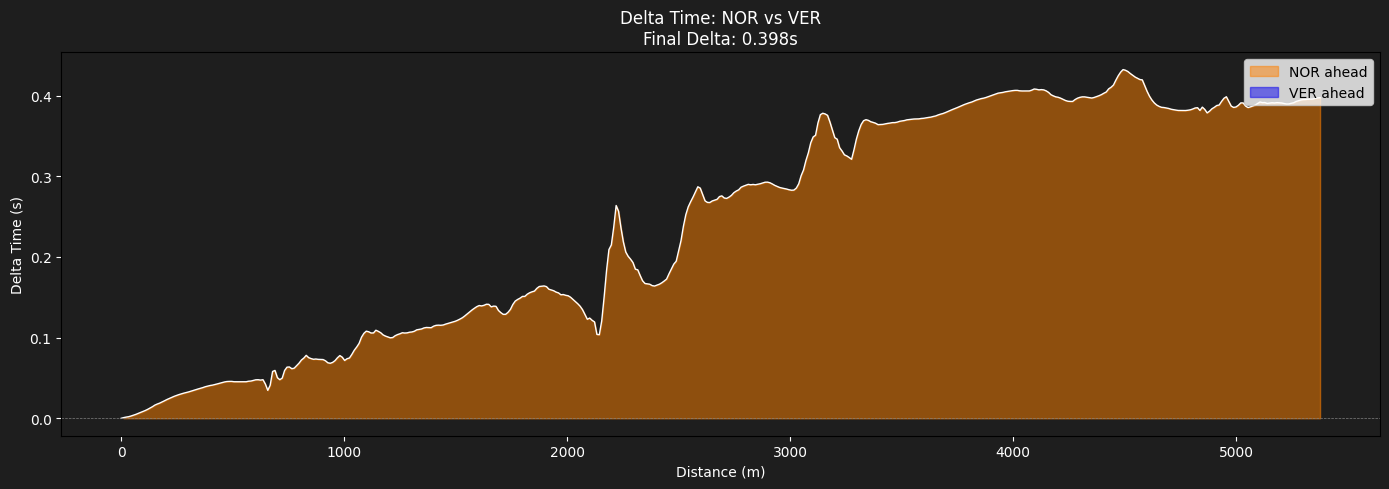

In [7]:
# Calculate delta time
from fastf1.core import Telemetry

# Interpolate to common distance points
common_distance = np.linspace(0, min(tel1['Distance'].max(), tel2['Distance'].max()), 500)

time1 = np.interp(common_distance, tel1['Distance'], tel1['Time'].dt.total_seconds())
time2 = np.interp(common_distance, tel2['Distance'], tel2['Time'].dt.total_seconds())
delta = time2 - time1  # Positive = driver1 ahead

fig, ax = plt.subplots(figsize=(14, 5), facecolor='#1e1e1e')
ax.set_facecolor('#1e1e1e')

# Fill areas
ax.fill_between(common_distance, delta, 0, where=(delta > 0), 
                color=color1, alpha=0.5, label=f'{lap1["Driver"]} ahead')
ax.fill_between(common_distance, delta, 0, where=(delta < 0), 
                color=color2, alpha=0.5, label=f'{lap2["Driver"]} ahead')

ax.plot(common_distance, delta, color='white', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('Distance (m)', color='white')
ax.set_ylabel('Delta Time (s)', color='white')
ax.tick_params(colors='white')
ax.legend(loc='upper right')

plt.title(f"Delta Time: {lap1['Driver']} vs {lap2['Driver']}\nFinal Delta: {delta[-1]:.3f}s", 
          color='white', fontsize=12)
plt.tight_layout()
plt.show()

## 5. Racing Line Animation
Animated racing line showing car position progression.

In [8]:
# Create Racing Line Animation
def create_racing_line_animation(telemetry, driver_name, team_color, frames=200):
    """
    Create animated racing line visualization.
    """
    x = telemetry['X'].values
    y = telemetry['Y'].values
    speed = telemetry['Speed'].values
    
    # Downsample for animation
    step = max(1, len(x) // frames)
    x_anim = x[::step]
    y_anim = y[::step]
    speed_anim = speed[::step]
    
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
    ax.set_facecolor('black')
    
    # Plot full track outline
    ax.plot(x, y, color='gray', linewidth=1, alpha=0.3)
    
    # Initialize car marker and trail
    trail, = ax.plot([], [], color=team_color, linewidth=3, alpha=0.8)
    car, = ax.plot([], [], 'o', color=team_color, markersize=12)
    speed_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                         color='white', fontsize=12, verticalalignment='top')
    
    ax.set_xlim(x.min() - 100, x.max() + 100)
    ax.set_ylim(y.min() - 100, y.max() + 100)
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(f'{driver_name} - Racing Line Animation', color='white', fontsize=14)
    
    def init():
        trail.set_data([], [])
        car.set_data([], [])
        speed_text.set_text('')
        return trail, car, speed_text
    
    def animate(i):
        # Trail shows last 50 points
        start_idx = max(0, i - 50)
        trail.set_data(x_anim[start_idx:i+1], y_anim[start_idx:i+1])
        car.set_data([x_anim[i]], [y_anim[i]])
        speed_text.set_text(f'Speed: {speed_anim[i]:.0f} km/h')
        return trail, car, speed_text
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(x_anim), interval=50, blit=True)
    plt.close()
    return anim

print('Racing line animation function created.')
print('Use anim.save("output.mp4", writer="ffmpeg") to save as video.')

Racing line animation function created.
Use anim.save("output.mp4", writer="ffmpeg") to save as video.


In [ ]:
# Generate animation for fastest lap
fastest_lap = session.laps.pick_fastest()
tel = fastest_lap.get_telemetry()
team_color = fastf1.plotting.get_team_color(fastest_lap['Team'], session)

anim = create_racing_line_animation(tel, fastest_lap['Driver'], team_color)

# Display in notebook (requires ipympl or HTML)
from IPython.display import HTML
HTML(anim.to_jshtml())

## 6. Driver Battle Animation
Animate two cars racing on the same track.

In [ ]:
# Create Battle Animation between two drivers
def create_battle_animation(tel1, tel2, driver1, driver2, color1, color2, frames=200):
    """
    Create animated battle visualization between two drivers.
    """
    # Resample to same length
    length = min(len(tel1), len(tel2))
    step = max(1, length // frames)
    
    x1 = tel1['X'].values[::step]
    y1 = tel1['Y'].values[::step]
    x2 = tel2['X'].values[::step]
    y2 = tel2['Y'].values[::step]
    
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
    ax.set_facecolor('black')
    
    # Plot full track
    ax.plot(tel1['X'], tel1['Y'], color='gray', linewidth=1, alpha=0.3)
    
    # Initialize car markers
    car1, = ax.plot([], [], 'o', color=color1, markersize=15, label=driver1)
    car2, = ax.plot([], [], 'o', color=color2, markersize=15, label=driver2)
    
    # Trails
    trail1, = ax.plot([], [], color=color1, linewidth=2, alpha=0.6)
    trail2, = ax.plot([], [], color=color2, linewidth=2, alpha=0.6)
    
    ax.legend(loc='upper right', facecolor='black', labelcolor='white')
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(f'{driver1} vs {driver2} - Battle Animation', color='white', fontsize=14)
    
    def init():
        car1.set_data([], [])
        car2.set_data([], [])
        trail1.set_data([], [])
        trail2.set_data([], [])
        return car1, car2, trail1, trail2
    
    def animate(i):
        start_idx = max(0, i - 30)
        trail1.set_data(x1[start_idx:i+1], y1[start_idx:i+1])
        trail2.set_data(x2[start_idx:i+1], y2[start_idx:i+1])
        car1.set_data([x1[i]], [y1[i]])
        car2.set_data([x2[i]], [y2[i]])
        return car1, car2, trail1, trail2
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=min(len(x1), len(x2)), interval=50, blit=True)
    plt.close()
    return anim

print('Battle animation function created.')

In [ ]:
# Generate battle animation
battle_anim = create_battle_animation(tel1, tel2, lap1['Driver'], lap2['Driver'], color1, color2)

# Display
HTML(battle_anim.to_jshtml())

## 7. Speed Trace Animation
Animated speed graph showing progression through the lap.

In [ ]:
# Create Speed Trace Animation
def create_speed_animation(telemetry, driver_name, team_color):
    """
    Create animated speed trace visualization.
    """
    tel = telemetry.add_distance()
    distance = tel['Distance'].values
    speed = tel['Speed'].values
    
    # Downsample
    step = max(1, len(distance) // 200)
    dist = distance[::step]
    spd = speed[::step]
    
    fig, ax = plt.subplots(figsize=(14, 5), facecolor='#1e1e1e')
    ax.set_facecolor('#1e1e1e')
    
    # Plot background track
    ax.plot(dist, spd, color='gray', linewidth=1, alpha=0.3)
    
    line, = ax.plot([], [], color=team_color, linewidth=2)
    point, = ax.plot([], [], 'o', color=team_color, markersize=10)
    
    ax.set_xlim(0, dist.max())
    ax.set_ylim(0, spd.max() + 20)
    ax.set_xlabel('Distance (m)', color='white')
    ax.set_ylabel('Speed (km/h)', color='white')
    ax.tick_params(colors='white')
    ax.set_title(f'{driver_name} - Speed Trace Animation', color='white')
    
    def init():
        line.set_data([], [])
        point.set_data([], [])
        return line, point
    
    def animate(i):
        line.set_data(dist[:i+1], spd[:i+1])
        point.set_data([dist[i]], [spd[i]])
        return line, point
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(dist), interval=30, blit=True)
    plt.close()
    return anim

# Generate speed animation
speed_anim = create_speed_animation(tel1, lap1['Driver'], color1)
HTML(speed_anim.to_jshtml())

## 8. Gear and DRS Animation
Visualize gear changes and DRS activation through the lap.

In [ ]:
# Create Gear/DRS Animation
def create_gear_drs_animation(telemetry, driver_name, team_color):
    """
    Create animated gear and DRS visualization.
    """
    tel = telemetry.add_distance()
    distance = tel['Distance'].values
    gear = tel['nGear'].values
    drs = tel['DRS'].values if 'DRS' in tel.columns else np.zeros_like(gear)
    
    step = max(1, len(distance) // 200)
    dist = distance[::step]
    gears = gear[::step]
    drs_data = drs[::step]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), facecolor='#1e1e1e')
    
    for ax in axes:
        ax.set_facecolor('#1e1e1e')
        ax.tick_params(colors='white')
    
    # Gear plot
    axes[0].plot(dist, gears, color='gray', linewidth=1, alpha=0.3)
    gear_line, = axes[0].plot([], [], color=team_color, linewidth=2)
    axes[0].set_ylabel('Gear', color='white')
    axes[0].set_ylim(0, 9)
    
    # DRS plot
    axes[1].plot(dist, drs_data, color='gray', linewidth=1, alpha=0.3)
    drs_line, = axes[1].plot([], [], color='#00FF00', linewidth=2)
    axes[1].set_ylabel('DRS', color='white')
    axes[1].set_xlabel('Distance (m)', color='white')
    
    fig.suptitle(f'{driver_name} - Gear & DRS Animation', color='white')
    
    def init():
        gear_line.set_data([], [])
        drs_line.set_data([], [])
        return gear_line, drs_line
    
    def animate(i):
        gear_line.set_data(dist[:i+1], gears[:i+1])
        drs_line.set_data(dist[:i+1], drs_data[:i+1])
        return gear_line, drs_line
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(dist), interval=30, blit=True)
    plt.close()
    return anim

gear_anim = create_gear_drs_animation(tel1, lap1['Driver'], color1)
HTML(gear_anim.to_jshtml())

## 9. Export Functions for Streamlit
Helper functions to generate static frames and data for Streamlit dashboard.

In [ ]:
# Streamlit Export Functions
def get_track_data(session):
    """Get track layout data for Streamlit map."""
    fastest = session.laps.pick_fastest()
    tel = fastest.get_telemetry()
    return {
        'x': tel['X'].tolist(),
        'y': tel['Y'].tolist(),
        'speed': tel['Speed'].tolist()
    }

def get_driver_telemetry(session, driver_code):
    """Get driver telemetry for Streamlit charts."""
    lap = session.laps.pick_driver(driver_code).pick_fastest()
    tel = lap.get_telemetry().add_distance()
    return {
        'distance': tel['Distance'].tolist(),
        'speed': tel['Speed'].tolist(),
        'throttle': tel['Throttle'].tolist(),
        'brake': tel['Brake'].tolist(),
        'gear': tel['nGear'].tolist(),
        'drs': tel['DRS'].tolist() if 'DRS' in tel.columns else []
    }

def generate_animation_frames(telemetry, num_frames=100):
    """Generate frame data for Streamlit animation."""
    x = telemetry['X'].values
    y = telemetry['Y'].values
    
    step = max(1, len(x) // num_frames)
    frames = []
    
    for i in range(0, len(x), step):
        frames.append({
            'x': x[i],
            'y': y[i],
            'trail_x': x[max(0, i-30):i+1].tolist(),
            'trail_y': y[max(0, i-30):i+1].tolist()
        })
    
    return frames

print('Streamlit export functions ready.')
print('Use these in src/fastf1_loader.py for dashboard integration.')

In [ ]:
# Save Animation to MP4 (requires FFmpeg)
def save_animation(anim, filename, fps=30):
    """
    Save animation to MP4 file.
    Requires FFmpeg installed on system.
    """
    try:
        writer = animation.FFMpegWriter(fps=fps, bitrate=1800)
        anim.save(filename, writer=writer)
        print(f'Animation saved to: {filename}')
    except Exception as e:
        print(f'Error saving animation: {e}')
        print('Make sure FFmpeg is installed: conda install ffmpeg')

# Example: save_animation(anim, '../output/racing_line.mp4')
print('Animation save function ready.')

---

## Summary

This notebook provides comprehensive FastF1 animation capabilities:

1. **Racing Line Visualization** - Track map colored by speed
2. **Driver Telemetry Comparison** - Multi-panel speed/throttle/brake/gear
3. **Delta Time Analysis** - Time gap visualization
4. **Racing Line Animation** - Animated car position
5. **Driver Battle Animation** - Two cars racing
6. **Speed Trace Animation** - Progressive speed graph
7. **Gear/DRS Animation** - Gear changes and DRS activation
8. **Streamlit Export** - Helper functions for dashboard

**Requirements:**
- FastF1 >= 3.0
- Matplotlib
- FFmpeg (for video export)

---
*Created with FastF1 Telemetry Animation Pipeline*